Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from torchmetrics import Accuracy, Precision, Recall
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random

General configuration: defining hyperparameters for the training process

In [2]:
NUM_CLASSES = 10 #n. of genres
BATCH_SIZE = 60 #number of samples per training iteration
LEARNING_RATE = 0.001 #rate at which model weights are updated
NUM_EPOCHS = 20
IMG_SIZE = 128  #target dim for image resizing
VAL_SPLIT_RATIO = 0.20 #20% of the training data will be used for validation

GPU if available

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


To ensure that initialization of weights and data processing is deterministic across multple runs

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Defining paths

In [5]:
train_data_dir = r'C:\Users\giann\Desktop\universita\magistrale\FUNDATIONS OF DATA SCIENCE\progetto finale\Data\Dataset_Spectrogram\train'
test_data_dir = r'C:\Users\giann\Desktop\universita\magistrale\FUNDATIONS OF DATA SCIENCE\progetto finale\Data\Dataset_Spectrogram\test'

Creating a pipeline that standardizes input images: first resizes all input images to 128 pixels, then concerts the image into a tensor and scales pixel values from [0,255] to [0, 1]

In [6]:
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Defining network: it is composed of two main sections: feature extractor (using convolutional blocks) and the classifier (using fully connected layers)

*   Block 1: Future extraction: 128x128 --> 64x64. In this block there are convolution, normalization, activation and pooling.
*   Block 2: Future extraction: 64x64 --> 32x32. In this block also there are convolution, normalization, activation and pooling.

Then we have a classifier head, that takes the extracted featres and converts them into final class prob. It's a sequence if linear layer: relu, dropout and 2 nn.linear.

The forward pass defines the execution flow for an input tensor x. It applies 2 times the feature extraction, then flatts the tensor and at the end the flattened vector is passed through a classification head to produces the classification



In [ ]:
import torch.nn as nn

class SpectrogramCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SpectrogramCNN, self).__init__()

        # Block 1: Feature extraction. Reduces spatial dim by half (e.g., 128->64).
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),  # Normalizes output for stable training
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2: Increases depth (16->32 filters) and reduces spatial dim again (e.g., 64->32).
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Flatten input size calculation (assumes input image was 128x128).
        self.fc_input_size = 32 * 32 * 32

        self.flatten = nn.Flatten()

        # Classification head with Dropout to prevent overfitting.
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes) # Final output scores
        )

    def forward(self, x):
        # Pass input through convolutional blocks then flatten for the classifier
        x = self.block1(x)
        x = self.block2(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

Function used to evaluate model's performance for a single epoch

In [ ]:
# --- VALIDATION FUNCTION ---
def validate_epoch(model, dataloader, device):
    # Set model to evaluation mode (disables dropout/batchnorm updates)
    model.eval()
    acc_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
    
    # Disable gradient calculation to save memory and compute
    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            
            # Get class index with the highest probability
            _, preds = torch.max(outputs, 1)
            acc_metric.update(preds, targets)
            
    # Calculate and return the final accuracy score
    return acc_metric.compute().item()

The function runs the model on the dedicated test set to measure its performance.


In [ ]:
def test_model(model, dataloader, device, class_names):
    # Initialize metrics for multiclass evaluation
    acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
    precision = Precision(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
    recall = Recall(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)

    model.eval() # Set model to eval mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Update running metrics
            acc.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)

            # Move to CPU/Numpy for sklearn report and plotting
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nTest Accuracy: {acc.compute():.4f}")
    print(f"Test Macro Precision: {precision.compute():.4f}")
    print("\nClassification Report (Test Set):")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Visualize performance with a Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.show()

    return acc.compute()

Main execution section: load and prepare the data to train the CNN and running the final evaluation

Dataset Training: 3829 | Validation: 957 | Test: 1199

--- Starting training  ---


Epoch 1/20: 100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Loss: 3.2351 | Val Acc: 0.3605


Epoch 2/20: 100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Loss: 1.7888 | Val Acc: 0.4525


Epoch 3/20: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]


Loss: 1.5929 | Val Acc: 0.4744


Epoch 4/20: 100%|██████████| 64/64 [00:54<00:00,  1.17it/s]


Loss: 1.5022 | Val Acc: 0.5601


Epoch 5/20: 100%|██████████| 64/64 [00:58<00:00,  1.09it/s]


Loss: 1.3574 | Val Acc: 0.6228


Epoch 6/20: 100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Loss: 1.2505 | Val Acc: 0.6385


Epoch 7/20: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Loss: 1.1789 | Val Acc: 0.6782


Epoch 8/20: 100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Loss: 1.0861 | Val Acc: 0.6949


Epoch 9/20: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Loss: 1.0128 | Val Acc: 0.6959


Epoch 10/20: 100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Loss: 0.9510 | Val Acc: 0.7032


Epoch 11/20: 100%|██████████| 64/64 [00:59<00:00,  1.08it/s]


Loss: 0.8956 | Val Acc: 0.7419


Epoch 12/20: 100%|██████████| 64/64 [00:57<00:00,  1.12it/s]


Loss: 0.8266 | Val Acc: 0.7419


Epoch 13/20: 100%|██████████| 64/64 [01:00<00:00,  1.07it/s]


Loss: 0.7608 | Val Acc: 0.7450


Epoch 14/20: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Loss: 0.7053 | Val Acc: 0.7346


Epoch 15/20: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Loss: 0.7244 | Val Acc: 0.7659


Epoch 16/20: 100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Loss: 0.7933 | Val Acc: 0.7440


Epoch 17/20: 100%|██████████| 64/64 [00:58<00:00,  1.09it/s]


Loss: 0.6904 | Val Acc: 0.7409


Epoch 18/20: 100%|██████████| 64/64 [01:08<00:00,  1.06s/it]


Loss: 0.6411 | Val Acc: 0.7555


Epoch 19/20: 100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Loss: 0.6204 | Val Acc: 0.7597


Epoch 20/20: 100%|██████████| 64/64 [00:52<00:00,  1.21it/s]


Loss: 0.5852 | Val Acc: 0.7586


Testing: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]



Test Accuracy: 0.7239
Test Macro Precision: 0.7324

Classification Report (Test Set):
              precision    recall  f1-score   support

       blues       0.85      0.62      0.72       120
   classical       0.91      0.88      0.89       120
     country       0.75      0.62      0.68       119
       disco       0.63      0.67      0.65       120
      hiphop       0.74      0.75      0.75       120
        jazz       0.67      0.79      0.73       120
       metal       0.86      0.87      0.86       120
         pop       0.62      0.88      0.73       120
      reggae       0.68      0.61      0.64       120
        rock       0.62      0.54      0.58       120

    accuracy                           0.72      1199
   macro avg       0.73      0.72      0.72      1199
weighted avg       0.73      0.72      0.72      1199



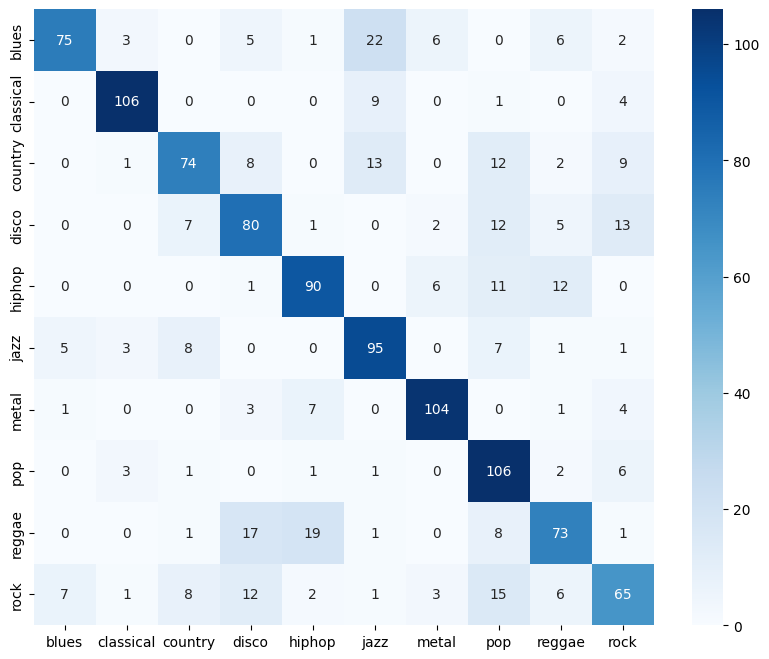

In [10]:
if __name__ == '__main__':
    set_seed(42) # Ensures results are reproducible every time you run
    
    # 1. LOAD DATA
    # Loads images from folders where folder names = class labels
    full_train_dataset = datasets.ImageFolder(root=train_data_dir, transform=data_transforms)
    test_dataset = datasets.ImageFolder(root=test_data_dir, transform=data_transforms)

    # Split training data to create a Validation set (e.g., 80% train / 20% val)
    val_size = int(VAL_SPLIT_RATIO * len(full_train_dataset))
    train_size = len(full_train_dataset) - val_size
    train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, val_size])

    # Create loaders to handle batching and shuffling
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    class_names = full_train_dataset.classes
    print(f"Dataset Training: {len(train_dataset)} | Validation: {len(validation_dataset)} | Test: {len(test_dataset)}")

    # 2. INITIALIZATION
    model = SpectrogramCNN(in_channels=3, num_classes=NUM_CLASSES).to(DEVICE) # Move model to GPU/CPU
    criterion = nn.CrossEntropyLoss() # Standard loss for multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Updates weights
    best_val_acc = 0.0

    # 3. TRAINING LOOP
    print("\n--- Starting training  ---")

    for epoch in range(NUM_EPOCHS):
        model.train() # Enable layers like Dropout/BatchNorm
        epoch_loss = 0.0

        for data, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}"):
            data, targets = data.to(DEVICE), targets.to(DEVICE)

            # Forward pass: compute predictions and loss
            scores = model(data)
            loss = criterion(scores, targets)

            # Backward pass: compute gradients and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.size(0)

        total_train_loss = epoch_loss / len(train_dataset)
        
        # Check performance on unseen validation data after every epoch
        val_acc = validate_epoch(model, validation_loader, DEVICE)

        print(f"Loss: {total_train_loss:.4f} | Val Acc: {val_acc:.4f}")


    # 4. FINAL EVALUATION
    # Evaluate on the completely unseen Test set
    test_model(model, test_loader, DEVICE, class_names)